In [ ]:
!pip install tensorflow-gpu
!pip install opencv-python
!pip install opencv-contrib-python
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf ## pip instal tensorflow-gpu
import cv2

import os
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_array = cv2.imread("/content/drive/MyDrive/DrowsinessDetection/Test_Dataset/Closed_Eyes/s0001_00002_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)

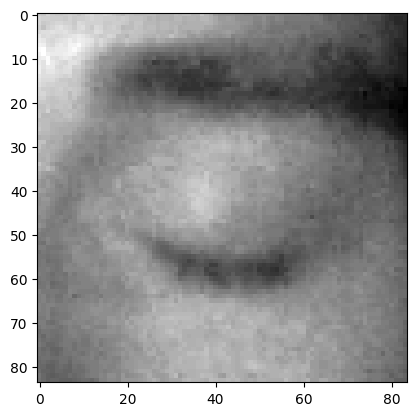

In [ ]:
plt.imshow(img_array, cmap ="gray")

In [ ]:
img_array.shape

(84, 84)

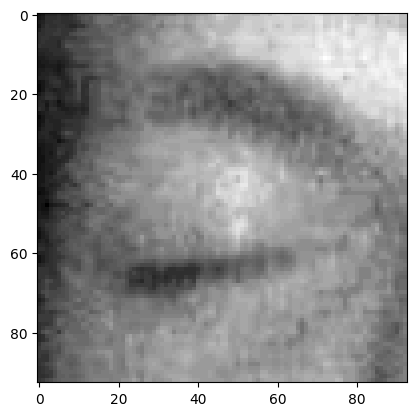

In [ ]:
Datadirectory = "/content/drive/MyDrive/DrowsinessDetection/Test_Dataset/" ## training dataset
Classes = ["Closed_Eyes", "Open_Eyes"] ## list of classes
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap = "gray")
        plt.show()
        break
    break





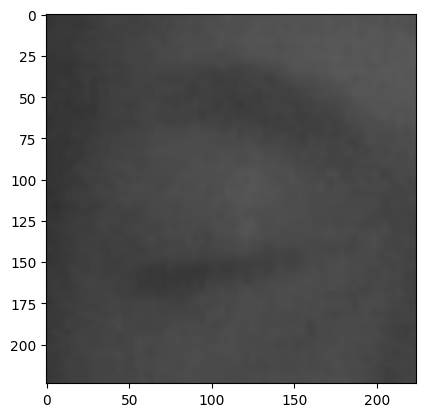

In [ ]:
img_size = 224

new_array = cv2.resize(backtorgb, (img_size,img_size))
plt.imshow(new_array, cmap ="gray")
plt.show()

In [ ]:
from pyparsing.common import ParseBaseException
# reading all the images and converting them
#into an array for data and labels

training_Data = []

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) ## 0 1,
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass



In [ ]:
create_training_Data()

In [ ]:
print(len(training_Data))

2800


In [ ]:
import random

random.shuffle(training_Data)

In [ ]:
X = []
y = []

for features, label in training_Data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)

In [ ]:
X.shape

(2800, 224, 224, 3)

In [ ]:
#normalize the data
#we can use sklearn as well to normalize it for now just doing it with 255
X=X/255.0; ## we are normalizing it

In [ ]:
#Converting Labels in numpy array
Y = np.array(y)

In [ ]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

## ***Deep Learning Model for training - Training Learning***

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()
# Note: Check with Other application i.e, application.Imagenet and others they would be huge

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

# **Transfer Learning**

In [ ]:
#Intial Layer is 0
base_input = model.layers[0].input ##input

In [ ]:
#Rather counting it from 1 here we can start from -1 i.e a dropout layer here we are using base_output as dropout layer
#by ignoring all the three bottom layers from down
base_output = model.layers[-4].output

In [ ]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) ## As Dense layer is Fully connected Rather than having 1000 layers
## better to have one node(1 or 0) ==> for one node it's binaray classification
final_output = layers.Activation('sigmoid')(final_output)

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

Settings for Binary Classification (Open/Closed)

In [ ]:
new_model.compile(loss = "binary_crossentropy", optimizer="adam", metrics = ["accuracy"])
#Also try with RMSProp new_model.compile(loss = "binary_crossentropy", optimizer="RMSprop", metrics = ["accuracy"])


In [ ]:
new_model.fit(X,Y, epochs = 16 , validation_split=0.1) ## training
# new_model.fit(X,Y, epochs = 8, validation_split=0.1) ## training
# new_model.fit(X,Y, epochs = 2, validation_split=0.1) ## training


Epoch 1/16
79/79 [==============================] - 37s 173ms/step - loss: 0.1442 - accuracy: 0.9627 - val_loss: 0.1722 - val_accuracy: 0.9536
Epoch 2/16
79/79 [==============================] - 12s 158ms/step - loss: 0.0171 - accuracy: 0.9960 - val_loss: 0.7004 - val_accuracy: 0.8786
Epoch 3/16
79/79 [==============================] - 13s 158ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0211 - val_accuracy: 0.9964
Epoch 4/16
79/79 [==============================] - 13s 163ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0422 - val_accuracy: 0.9857
Epoch 5/16
79/79 [==============================] - 13s 160ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 0.0407 - val_accuracy: 0.9929
Epoch 6/16
79/79 [==============================] - 12s 158ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/16
79/79 [==============================] - 12s 158ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 4.2427e-04 - val_accuracy: 1.

In [ ]:
new_model.save('/content/drive/MyDrive/DrowsinessDetection/drowsiness_detect_model_t1_adam.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/DrowsinessDetection/drowsiness_detect_model_t1_adam.h5')
new_model = tf.keras.models.load_model('/content/drive/MyDrive/DrowsinessDetection/drowsiness_detect_model.h5')

Checking the network for predictions

In [ ]:
img_array = cv2.imread('/content/drive/MyDrive/DrowsinessDetection/s0012_00280_0_0_0_0_1_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))


In [ ]:
X_input = np.array(new_array).reshape(1, img_size, img_size, 3)

In [ ]:
X_input.shape

(1, 224, 224, 3)

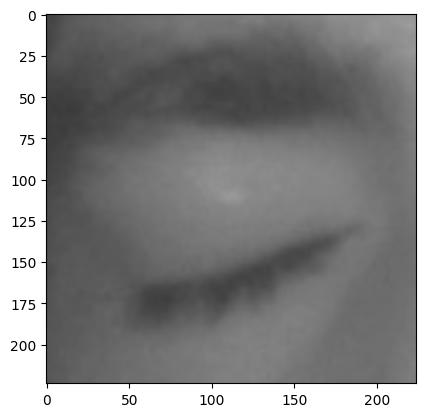

In [ ]:
plt.imshow(new_array)

In [ ]:
#Normalizing it
X_input = X_input/255.0

In [ ]:
prediction = new_model.predict(X_input)

1/1 [==============================] - 1s 787ms/step


In [ ]:
prediction
#If the value in the array is +ve eyes are open and
#if the value in the array is -ve eyes are closed

array([[1.6099232e-08]], dtype=float32)

For Unknown Images

In [ ]:
img = cv2.imread('/content/drive/MyDrive/DrowsinessDetection/Test_Dataset/ManwithClosedEye.png')

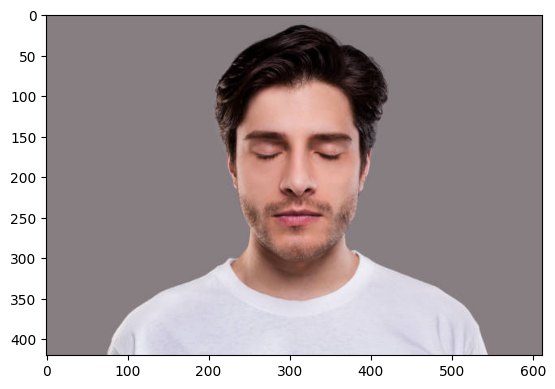

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

In [ ]:
for(x, y, w, h) in eyes:
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)

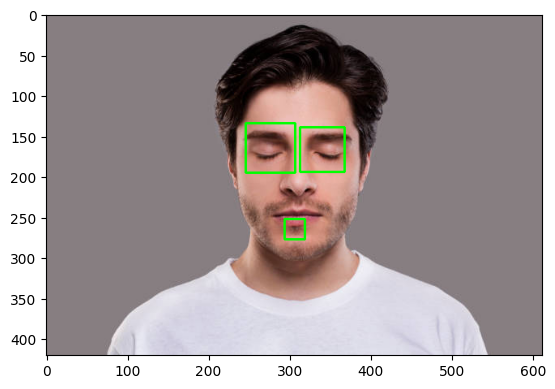

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Cropping the Eye Image

In [ ]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex, ey, ew, eh) in eyess:
            eyes_roi = roi_color[ey: ey+eh, ex: ex+ew]



eyes are not detected


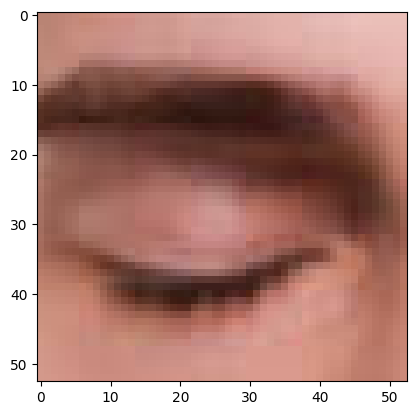

In [ ]:
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [ ]:
eyes_roi.shape

(53, 53, 3)

In [ ]:
final_image = cv2.resize(eyes_roi, (224, 224))
final_image = np.expand_dims(final_image, axis=0) ## need fourth dimension
final_image = final_image/255.0

In [ ]:
final_image.shape

(1, 224, 224, 3)

In [ ]:
Preds = new_model.predict(final_image)
Preds

1/1 [==============================] - 0s 43ms/step


array([[1.7131406e-07]], dtype=float32)

**Live Demo**

**1st Detect that eyes are closed or open**

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


In [ ]:
# # start streaming video from webcam
# video_stream()
# # label for video
# label_html = 'Capturing...'
# # initialze bounding box to empty
# bbox = ''
# count = 0
# while True:
#     js_reply = video_frame(label_html, bbox)
#     if not js_reply:
#         break

#     # convert JS response to OpenCV Image
#     img = js_to_image(js_reply["img"])

#     # create transparent overlay for bounding box
#     bbox_array = np.zeros([480,640,4], dtype=np.uint8)

#     # grayscale image for face detection
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     # get face region coordinates
#     faces = face_cascade.detectMultiScale(gray)
#     # get face bounding box for overlay
#     for (x,y,w,h) in faces:
#       bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

#     bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
#     # convert overlay of bbox into bytes
#     bbox_bytes = bbox_to_bytes(bbox_array)
#     # update bbox so next frame gets new overlay
#     bbox = bbox_bytes

In [ ]:
import IPython.display as ipd
import numpy as np
sound = []
def SoundNotification():
    global sound
    sr = 22050 # sample rate
    T = 1    # seconds
    t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
    x = 0.5*np.sin(2*np.pi*440*t)              # pure sine wave at 440 Hz
    sound = ipd.Audio(x, rate=sr, autoplay=True) # load a NumPy array

    return sound

def WhereIWantToUseTheSound():
    sound = SoundNotification()
    return sound

<IPython.core.display.Javascript object>

eyes= [[335 291  62  62]
 [420 314  46  46]]
False
1/1 [==============================] - 0s 21ms/step
Predictions Value: [[0.99340206]]


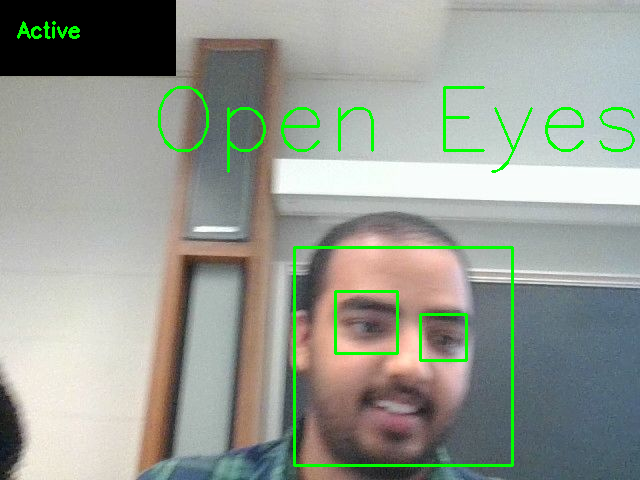

eyes= [[380 261  45  45]
 [299 266  44  44]]
False
1/1 [==============================] - 0s 20ms/step
Predictions Value: [[0.99257505]]


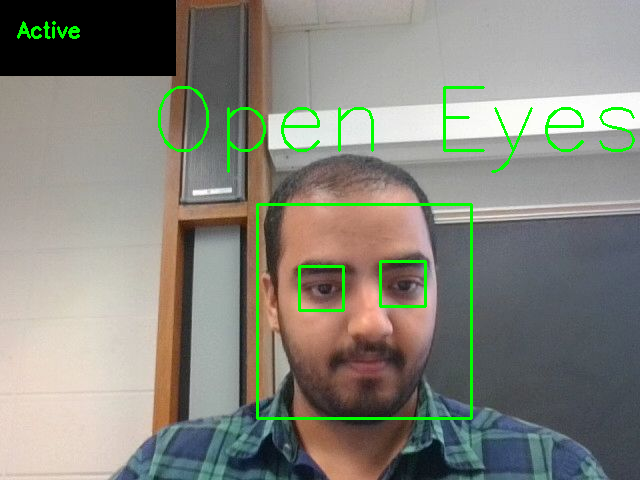

eyes= [[391 257  43  43]
 [305 255  50  50]]
False
1/1 [==============================] - 0s 22ms/step
Predictions Value: [[0.99995804]]


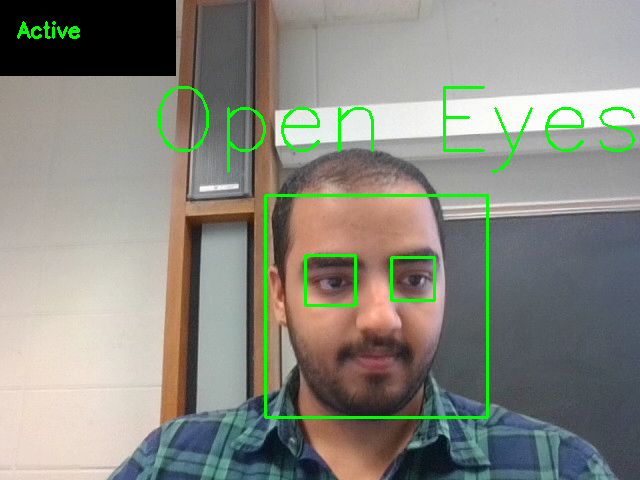

eyes= [[361 255  54  54]
 [276 242  73  73]]
Eyes are not detected
False
1/1 [==============================] - 0s 30ms/step
Predictions Value: [[5.6182618e-08]]


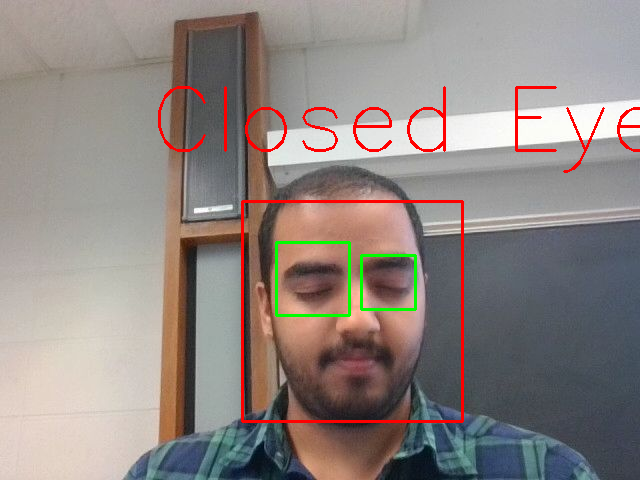

eyes= [[382 270  46  46]
 [304 274  44  44]]
False
1/1 [==============================] - 0s 21ms/step
Predictions Value: [[0.9980221]]


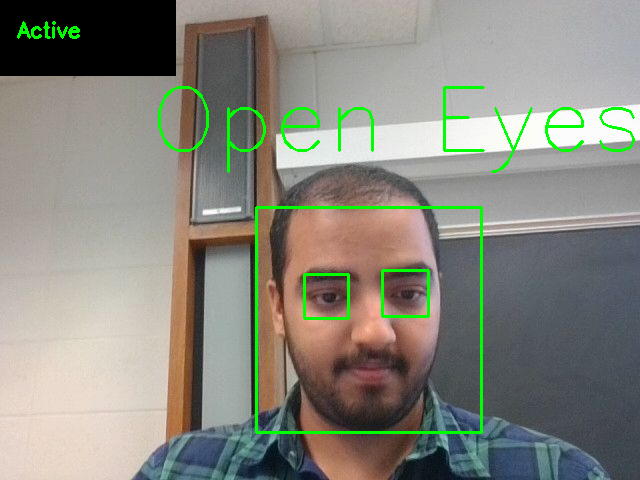

eyes= [[364 256  50  50]
 [291 264  44  44]
 [277 239  76  76]]
False
1/1 [==============================] - 0s 20ms/step
Predictions Value: [[0.9999217]]


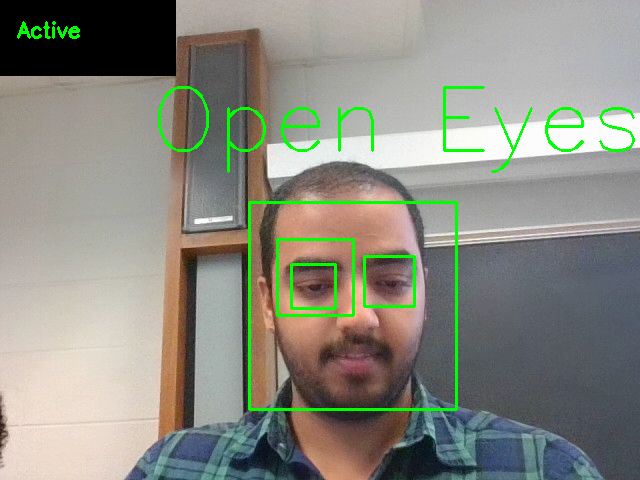

eyes= [[379 259  47  47]
 [298 245  62  62]]
Eyes are not detected
Eyes are not detected
False
1/1 [==============================] - 0s 21ms/step
Predictions Value: [[0.9999217]]


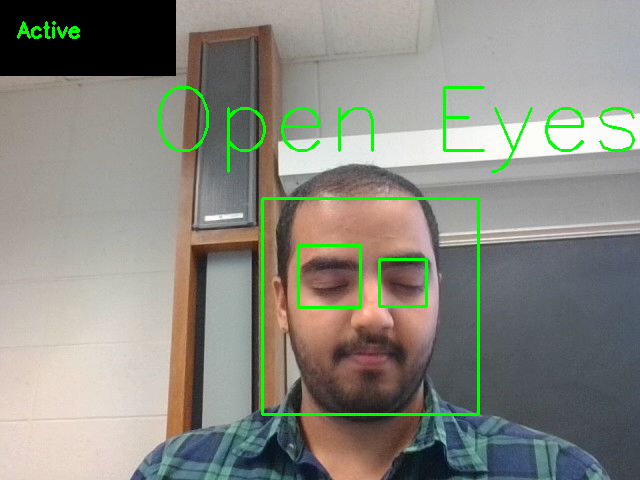

eyes= [[399 257  44  44]
 [319 255  48  48]]
False
1/1 [==============================] - 0s 57ms/step
Predictions Value: [[0.9997621]]


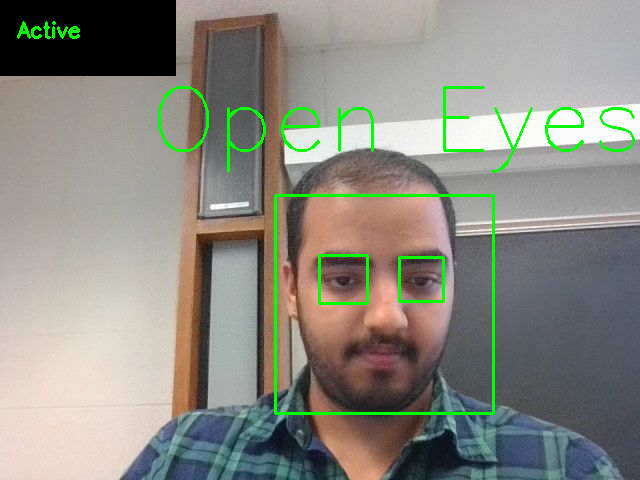

eyes= [[386 269  52  52]]
False
1/1 [==============================] - 0s 23ms/step
Predictions Value: [[0.04826351]]


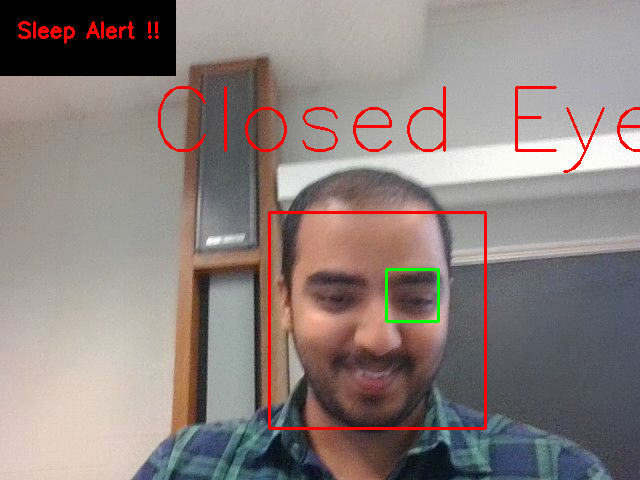

eyes= [[374 248  54  54]
 [291 239  68  68]]
Eyes are not detected
Eyes are not detected
False
1/1 [==============================] - 0s 23ms/step
Predictions Value: [[0.04826351]]


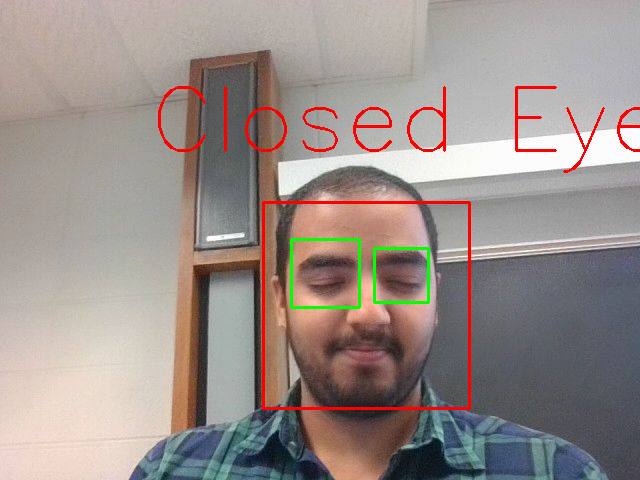

eyes= [[377 254  53  53]
 [295 240  70  70]]
Eyes are not detected
False
1/1 [==============================] - 0s 21ms/step
Predictions Value: [[0.02116545]]


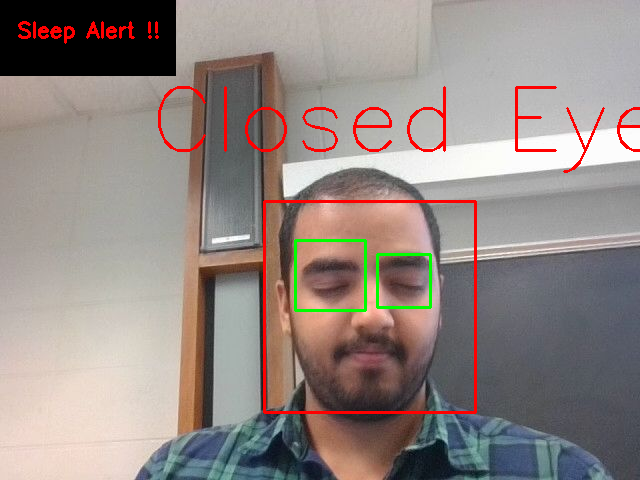

eyes= [[316 276  46  46]
 [396 278  44  44]]
False
1/1 [==============================] - 0s 46ms/step
Predictions Value: [[0.9999926]]


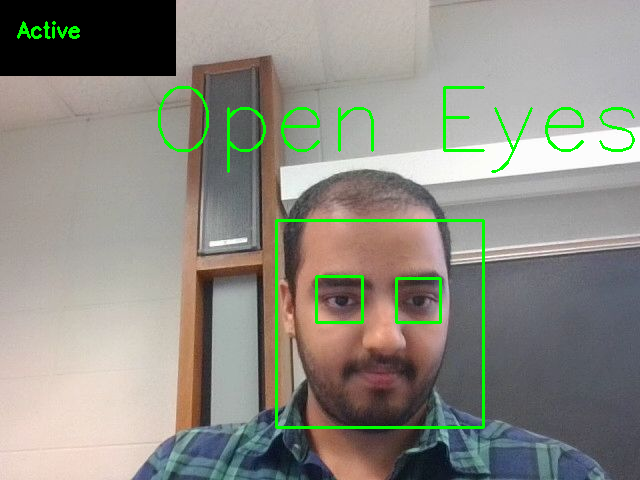

eyes= [[325 262  49  49]
 [403 268  47  47]]
False
1/1 [==============================] - 0s 21ms/step
Predictions Value: [[0.999874]]


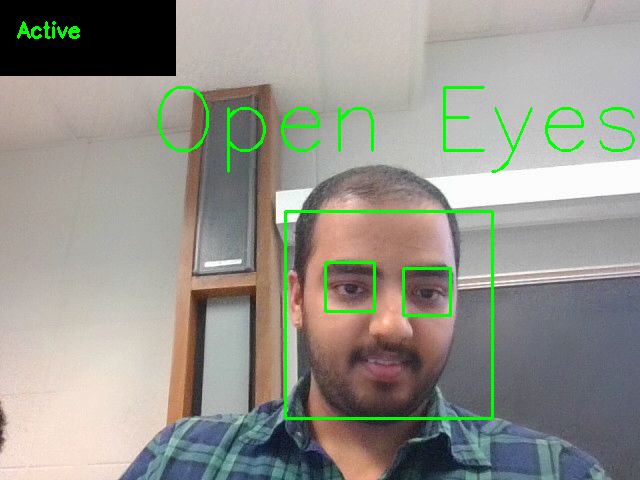

eyes= [[307 233  56  56]
 [382 256  43  43]]
Eyes are not detected
False
1/1 [==============================] - 0s 20ms/step
Predictions Value: [[0.99980026]]


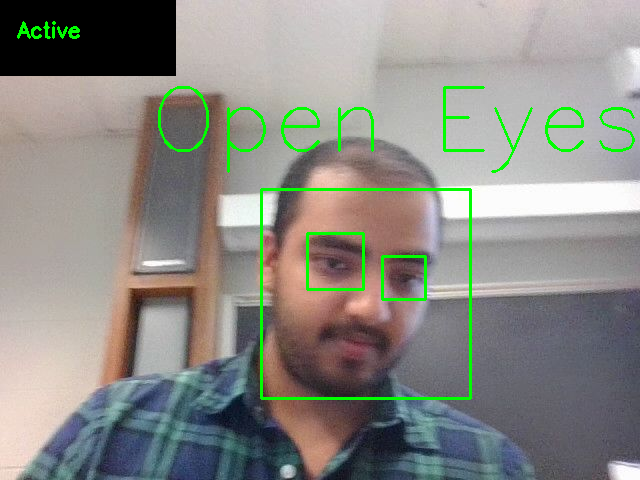

eyes= [[494 180  66  66]
 [271 210  38  38]
 [218 223  29  29]
 [210 226  25  25]
 [415 207  54  54]
 [208 208  57  57]]
Eyes are not detected
Eyes are not detected
False
1/1 [==============================] - 0s 26ms/step
Predictions Value: [[0.14694272]]


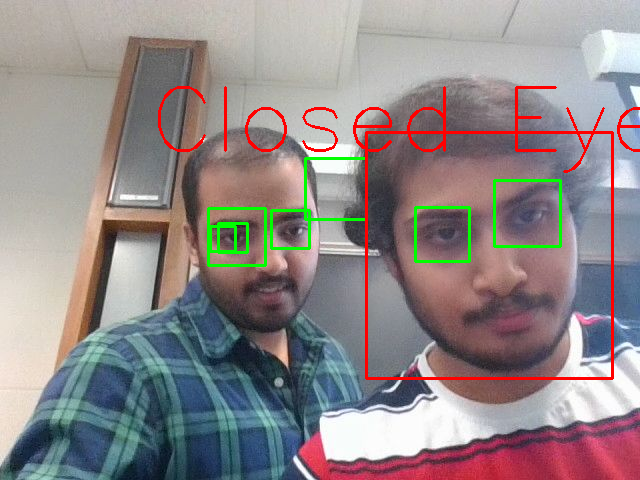

In [ ]:
# from IPython.display import Audio
# sound_file = 'https://www.soundjay.com/button/beep-01a.mp3'
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
# import winsound
import time

# import numpy

path = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')





# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to a NumPy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode the NumPy array into an OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV rectangle bounding box image into a base64 byte string
def bbox_to_bytes(bbox_array):
    # Convert array into a PIL image
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # Format the bounding box into PNG for return
    bbox_PIL.save(iobuf, format='png')
    # Format the return string
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
    display(js)

# Function to process a video frame
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Start streaming video from the webcam
video_stream()

# Label for video
label_html = 'Capturing...'
# Initialize bounding box to empty
bbox = ''

counter = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
    print("eyes=",eyes)

    for x, y, w, h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        eyess = eye_cascade.detectMultiScale(roi_gray)

        if len(eyess) == 0:
            print("Eyes are not detected")
        else:
            for (ex, ey, ew, eh) in eyess:
                eyes_roi = roi_color[ey: ey+eh, ex: ex+ew]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    # Draw a Rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    font = cv2.FONT_HERSHEY_SIMPLEX

    final_image = cv2.resize(eyes_roi, (224, 224))
    final_image = np.expand_dims(final_image, axis=0)  # Need a fourth dimension
    final_image = final_image / 255.0

    # Make predictions using your model (replace 'new_model' with your actual model)
    Predictions = new_model.predict(final_image)
    #finalPrediction = np.array_str(Predictions)
    print("Predictions Value:",Predictions)
    #if finalPrediction.__contains__('e'):
    if Predictions < 0.5:
        counter = counter + 1
        status = "Closed Eyes"
        cv2.putText(img, status, (150, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

        if counter > 1:
            x1, y1, w1, h1 = 0, 0, 175, 75

            # Draw a black background rectangle
            cv2.rectangle(img, (x1, x1), (x1+w1, y1+h1), (0, 0, 0), -1)

            # Add text

            WhereIWantToUseTheSound()
            cv2.putText(img, 'Sleep Alert !!', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            counter = 0
    else:
        status = "Open Eyes"
        cv2.putText(img, status, (150, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
        x1, y1, w1, h1 = 0, 0, 175, 75

        # Draw a black background rectangle
        cv2.rectangle(img, (x1, x1), (x1+w1, y1+h1), (0, 0, 0), -1)

        # Add text
        cv2.putText(img, 'Active', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2_imshow(img)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
